In [1]:
import fitsio as fio
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
cent = fio.FITS('/lsst/troxel/y1a1/lgt20_central_p20_fmasked.fits')[-1] # Central galaxy catalog (with shapes)
sat = fio.FITS('/lsst/troxel/y1a1/lgt20_satellite_p20_fmasked.fits')[-1] # Satellite p_mem >= 0.2 catalog
clus = fio.FITS('/lsst/troxel/y1a1/lgt20_cluster_p20_fmasked.fits')[-1] # Cluster catalog

In [3]:
def sat_num(sat=sat.read()):
    sat_id_unq, counts = np.unique(sat['MEM_MATCH_ID'], return_counts=True)
    clus_n = len(sat_id_unq)
    sat_max = np.amax(counts)
    
    return sat_id_unq, counts, clus_n, sat_max

In [4]:
sat_id_unq, counts, clus_n, sat_max = sat_num()

In [5]:
# Create 2D array for specified property of all satellite galaxies
def sat_prop(prop, sat=sat.read()):
    sat_id_unq, counts, clus_n, sat_max = sat_num(sat)
    sat_prop_full = sat[prop]
    new_array = np.zeros((clus_n,sat_max))
    k = 0
    for i in range(clus_n):
        new_array[i, 0:counts[i]] = sat_prop_full[k:k+counts[i]]
        new_array[i, counts[i]:] = np.nan
        k = k + counts[i]
    
    return new_array

In [55]:
# Create 2D array for specified property of all satellite galaxies
def sat_mag(band, sat=sat.read()):
    sat_id_unq, counts, clus_n, sat_max = sat_num(sat)
    sat_prop_full = sat['MODEL_MAG'][:,band]
    new_array = np.zeros((clus_n,sat_max))
    k = 0
    for i in range(clus_n):
        new_array[i, 0:counts[i]] = sat_prop_full[k:k+counts[i]]
        new_array[i, counts[i]:] = np.nan
        k = k + counts[i]
    
    return new_array

In [6]:
# Calculate satellite angular position for all clusters
def sat_ang_pos(cent=cent.read(), sat=sat.read()):
    clus_n = sat_num(sat)[2]
    sat_ra = np.radians(sat_prop('RA', sat))
    sat_dec = np.radians(sat_prop('DEC', sat))
    cent_ra = np.radians(cent['RA'].reshape((clus_n,-1)))
    cent_dec = np.radians(cent['DEC'].reshape((clus_n,-1)))
    x = np.sin(sat_dec) * np.cos(cent_dec) - np.cos(sat_dec) * np.sin(cent_dec) * np.cos(sat_ra-cent_ra)
    y = np.sin(sat_ra-cent_ra) * np.cos(sat_dec)
    theta = np.arctan2(y, x)
    
    return theta

In [7]:
def mom_2(p, x, y, a, b):
    mom_top = p*a*b/(x**2+y**2)
    mom_sum = np.sum(np.nan_to_num(mom_top), axis=1)/np.sum(np.nan_to_num(p), axis=1)
    
    return mom_sum

In [8]:
def clus_pa(cent=cent.read(), sat=sat.read()):
    sat_ang = sat_ang_pos(cent, sat)
    p_i = sat_prop('P', sat) * sat_prop('PFREE', sat)
    x_i = sat_prop('R', sat) * np.cos(sat_ang)
    y_i = sat_prop('R', sat) * np.sin(sat_ang)
    m_xx = mom_2(p_i, x_i, y_i, x_i, x_i)
    m_xy = mom_2(p_i, x_i, y_i, x_i, y_i)
    m_yy = mom_2(p_i, x_i, y_i, y_i, y_i)
    Q = m_xx - m_yy
    U = 2 * m_xy
    beta = np.arctan2(U, Q) / 2
    e = np.sqrt(Q**2 + U**2)
    
    return beta

In [9]:
def clus_e(cent=cent.read(), sat=sat.read()):
    sat_ang = sat_ang_pos(cent, sat)
    p_i = sat_prop('P', sat) * sat_prop('PFREE', sat)
    x_i = sat_prop('R', sat) * np.cos(sat_ang)
    y_i = sat_prop('R', sat) * np.sin(sat_ang)
    m_xx = mom_2(p_i, x_i, y_i, x_i, x_i)
    m_xy = mom_2(p_i, x_i, y_i, x_i, y_i)
    m_yy = mom_2(p_i, x_i, y_i, y_i, y_i)
    Q = m_xx - m_yy
    U = 2 * m_xy
    beta = np.arctan2(U, Q) / 2
    e = np.sqrt(Q**2 + U**2)
    
    return e

In [10]:
clus_elip = clus_e()

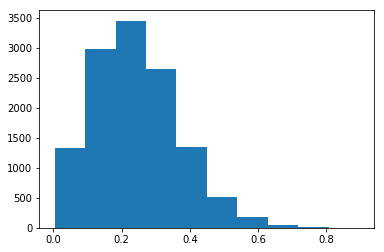

In [11]:
plt.hist(clus_elip, bins=10)
plt.show()

In [12]:
# Calculate position angle
def pos_ang(e1, e2):
    alpha = np.arctan2(-e2, -e1) / 2
    
    return alpha

In [13]:
def clus_align_ang(cent=cent.read(), sat=sat.read()):
    clus_ang = clus_pa(cent, sat)
    cent_ang = pos_ang(cent['e1'], cent['e2'])
    delta = clus_ang - cent_ang
    delta = np.arcsin(np.abs(np.sin(delta)))
    delta = np.degrees(delta)
    
    return delta

In [14]:
cente = np.sqrt((cent['e1'].read())**2 + (cent['e2'].read()**2))

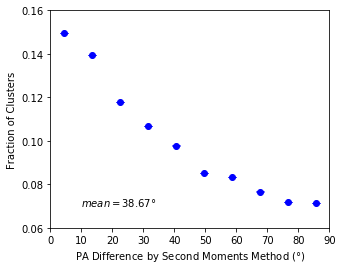

In [15]:
# Plot histogram of cluster alignment angle (with standard error of the mean)
clus_align = clus_align_ang()
n, bins = np.histogram(clus_align, bins=[0.,9.,18.,27.,36.,45.,54.,63.,72.,81., 90.])
k = 0
new_array = np.zeros(10)
for i in range(10):
    bin_i = clus_align[k:k+n[i]]
    std_i = np.std(bin_i)
    sem_i = std_i/np.sqrt(n[i])
    new_array[i] = sem_i
    k = k + n[i]
plt.errorbar(bins[0:10]+4.5, n/clus_n, yerr=new_array/clus_n, fmt='bo', capsize=4)
plt.xlabel(r'PA Difference by Second Moments Method ($\degree$)')
plt.ylabel('Fraction of Clusters')
plt.text(10, 0.07, '$mean=38.67\degree$')
plt.xlim(0, 90)
plt.ylim(0.06, 0.16)
f = plt.gcf()
f.set_size_inches(5., 4.)
plt.show()

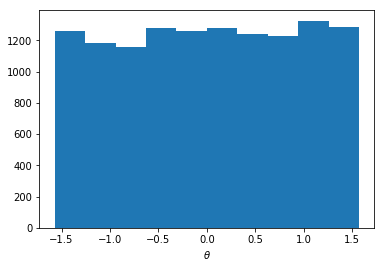

In [16]:
clus_ang = clus_pa()
plt.hist(clus_ang)
plt.xlabel(r'$\theta$')
plt.show()

In [17]:
#fio.write('/lsst/troxel/y1a1/lgt20_clus_ang_2mom.fits', clus_ang, clobber=True)

In [18]:
def clus_iter(prop, minimum, maximum, bins):
    bin_size = (maximum - minimum) / bins
    cents = []
    sats = []
    for i in range(bins):
        cent_mask = np.logical_and(np.less_equal(minimum + i*bin_size, prop), np.less_equal(prop, minimum + (i+1)*bin_size))
        cents.append(cent.read()[cent_mask])
        sat_mask = np.in1d(sat['MEM_MATCH_ID'].read(), cents[i]['MEM_MATCH_ID'], assume_unique=False)
        sats.append(sat.read()[sat_mask])
    
    return cents, sats

In [19]:
def clus_iter2(prop, bins):
    prop_sort = np.argsort(prop)
    prop_sorted = prop[prop_sort]
    bin_edges = prop_sorted[::clus_n//bins]
    cents = []
    sats = []
    for i in range(bins):
        cent_mask = np.logical_and(np.less_equal(bin_edges[i], prop), np.less_equal(prop, bin_edges[i+1]))
        cents.append(cent.read()[cent_mask])
        sat_mask = np.in1d(sat['MEM_MATCH_ID'].read(), cents[i]['MEM_MATCH_ID'], assume_unique=False)
        sats.append(sat.read()[sat_mask])
    
    return cents, sats, bin_edges

In [20]:
def align_iter(cent_cats, sat_cats):
    aligns = []
    means = []
    for i in range(len(cent_cats)):
        sat_id_unq, counts, clus_n, sat_max = sat_num(sat_cats[i])
        aligns.append(clus_align_ang(cent_cats[i], sat_cats[i]))
        means.append(np.sum(aligns[i])/clus_n)
    
    return aligns, means

In [21]:
def plot_iter(cent_cats, sat_cats):
    for i in range(len(cent_cats)):
        if len(cent_cats[i]) > 250:
            # Plot histogram of cluster alignment angle (with standard error of the mean)
            sat_id_unq, counts, clus_n, sat_max = sat_num(sat_cats[i])
            clus_align = clus_align_ang(cent=cent_cats[i], sat=sat_cats[i])
            n, bins = np.histogram(clus_align, bins=[0.,9.,18.,27.,36.,45.,54.,63.,72.,81., 90.])
            k = 0
            new_array = np.zeros(10)
            for i in range(10):
                bin_i = clus_align[k:k+n[i]]
                std_i = np.std(bin_i)
                sem_i = std_i/np.sqrt(n[i])
                new_array[i] = sem_i
                k = k + n[i]
            plt.errorbar(bins[0:10]+4.5, n/clus_n, yerr=new_array/clus_n, capsize=4)
            plt.xlabel(r'PA Difference ($\degree$)')
            plt.ylabel('Fraction of Clusters')
            plt.text(10, 0.05, str(clus_n))
            plt.xlim(0, 90)
            plt.ylim(0., 0.25)
            f = plt.gcf()
            f.set_size_inches(5., 4.)
            print(np.sum(clus_align)/clus_n)
            plt.show()
    
    return 1

In [22]:
def plot_iter2(cent_cats, sat_cats, bin_edges, prop, title):
    for i in range(len(cent_cats)):
        if len(cent_cats[i]) > 250:
            # Plot histogram of cluster alignment angle (with standard error of the mean)
            sat_id_unq, counts, clus_n, sat_max = sat_num(sat_cats[i])
            clus_align = clus_align_ang(cent=cent_cats[i], sat=sat_cats[i])
            n, bins = np.histogram(clus_align, bins=[0.,9.,18.,27.,36.,45.,54.,63.,72.,81., 90.])
            k = 0
            new_array = np.zeros(10)
            for j in range(10):
                bin_i = clus_align[k:k+n[j]]
                std_i = np.std(bin_i)
                sem_i = std_i/np.sqrt(n[j])
                new_array[j] = sem_i
                k = k + n[j]
            plt.errorbar(bins[0:10]+4.5, n/clus_n, yerr=new_array/clus_n, capsize=4, label=f'{bin_edges[i]:.2f} < {prop} < {bin_edges[i+1]:.2f}')
            plt.xlabel(r'PA Difference ($\degree$)')
            plt.ylabel('Fraction of Clusters')
            plt.title(title)
            plt.legend()
            #plt.text(10, 0.05, str(clus_n))
            #plt.xlim(0, 90)
            #plt.ylim(0., 0.25)
            #f = plt.gcf()
            #f.set_size_inches(5., 4.)
            print(np.sum(clus_align)/clus_n)
    plt.show()
    
    return

In [23]:
cent_z, sat_z = clus_iter(cent['Z'].read(), np.min(cent['Z'].read()), np.max(cent['Z'].read()), 3)

In [24]:
cent_z2, sat_z2, z_edges = clus_iter2(cent['Z'].read(), 3)

In [25]:
cent_e, sat_e = clus_iter(clus_elip, np.min(clus_elip), np.max(clus_elip), 10)

In [26]:
cent_lambda, sat_lambda = clus_iter(np.log10(clus['LAMBDA_CHISQ'].read()), np.min(np.log10(clus['LAMBDA_CHISQ'].read())), np.max(np.log10(clus['LAMBDA_CHISQ'].read())), 3)

In [27]:
cent_lambda2, sat_lambda2, lambda_edges = clus_iter2(np.log10(clus['LAMBDA_CHISQ'].read()), 3)

In [28]:
cent_cente, sat_cente = clus_iter(cente, np.min(cente), np.max(cente), 10)

In [29]:
cent_pcen, sat_pcen = clus_iter(clus['P_CEN'].read()[:,0], np.min(clus['P_CEN'].read()[:,0]), np.max(clus['P_CEN'].read()[:,0]), 10)

In [30]:
cent_rmag, sat_rmag = clus_iter(cent['MODEL_MAG'].read()[:, 1], np.min(cent['MODEL_MAG'].read()[:, 1]), np.max(cent['MODEL_MAG'].read()[:, 1]), 10)

In [31]:
cent_rmag2, sat_rmag2, rmag_edges = clus_iter2(cent['MODEL_MAG'].read()[:,1], 3)

In [32]:
cent_lum, sat_lum = clus_iter(clus['BCG_ZLUM'].read(), np.min(clus['BCG_ZLUM'].read()), np.max(clus['BCG_ZLUM'].read()), 10)

In [33]:
gr = cent['MODEL_MAG'].read()[:,0] - cent['MODEL_MAG'].read()[:,1]
cent_gr, sat_gr = clus_iter(gr, np.min(gr), np.max(gr), 3)

In [34]:
cent_gr2, sat_gr2, gr_edges = clus_iter2(gr, 3)

In [35]:
def dom():
    dom = np.zeros((clus_n))
    for i in range(clus_n):
        sats_mask = sat['MEM_MATCH_ID'].read()==cent['MEM_MATCH_ID'].read()[i]
        sats_mag = sat['MODEL_MAG'].read()[:,1][sats_mask]
        mag_sort = np.argsort(sats_mag)
        avg = (sats_mag[mag_sort[-1]]+sats_mag[mag_sort[-2]]) / 2
        dom[i] = cent['MODEL_MAG'].read()[:,1][i] - avg
    
    return dom

In [60]:
def dom2():
    cent_mag = cent['MODEL_MAG'].read()[:,1]
    sat_rmag = sat_mag(1)
    sat_sort = np.argsort(sat_rmag, axis=1)
    mag_1 = sat_rmag[sat_sort[-1,:]]
    mag_2 = sat_rmag[sat_sort[-2,:]]
    dom = cent_mag - (mag_1+mag_2) / 2

In [62]:
#cg_dom2 = dom2()

In [45]:
cg_dom = dom()

In [46]:
cent_dom, sat_dom = clus_iter(cg_dom, np.min(cg_dom), np.max(cg_dom), 3)

In [47]:
cent_dom2, sat_dom2, dom_edges = clus_iter2(cg_dom, 3)

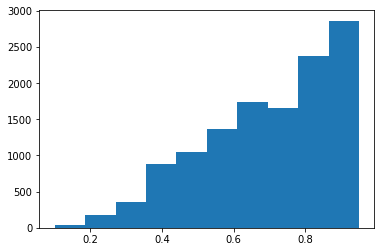

In [39]:
plt.hist(cent['Z'].read())
plt.show()

35.26353874884517
38.30042282884166
41.44356563821271


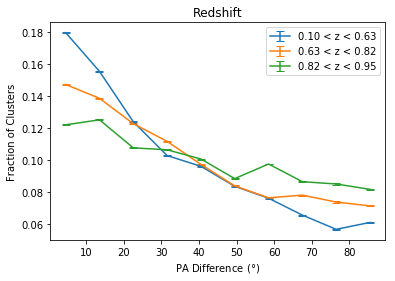

In [40]:
plot_iter2(cent_z2, sat_z2, z_edges, 'z', 'Redshift')

39.7801593740831
38.07613564976329
37.101110841093075


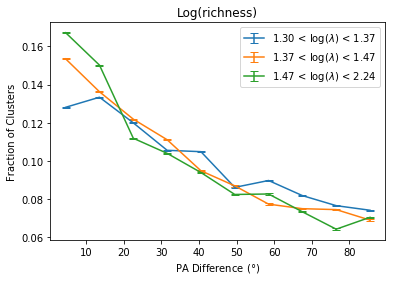

In [49]:
plot_iter2(cent_lambda2, sat_lambda2, lambda_edges, '$\log(\lambda)$', 'Log(richness)')

34.85932972600293
38.062673289598074
42.0920772801104


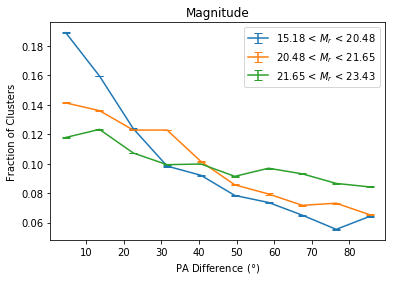

In [43]:
plot_iter2(cent_rmag2, sat_rmag2, rmag_edges, '$M_r$', 'Magnitude')

40.33673725198737
35.95934880941931
38.72197809681383


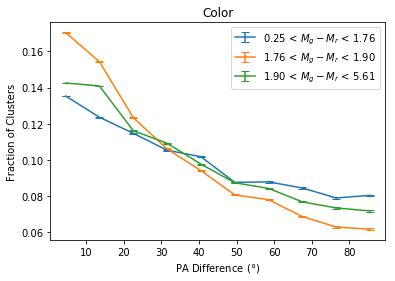

In [44]:
plot_iter2(cent_gr2, sat_gr2, gr_edges, '$M_g-M_r$', 'Color')

34.52602758001302
38.603295099305235
41.89242459068974


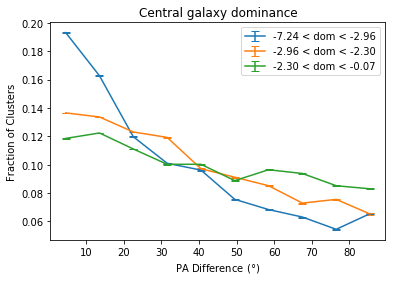

In [48]:
plot_iter2(cent_dom2, sat_dom2, dom_edges, 'dom', 'Central galaxy dominance')